In [ ]:
import numpy as np
import json
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l2
import os

# cd to your directory
data_directory = '/content/sample_data'
file_names = ['realistic_trajectory_data-3.json', 'realistic_trajectory_data-4.json', 'realistic_trajectory_data-5.json', 'realistic_trajectory_data-6.json', 'realistic_trajectory_data-7.json', 'realistic_trajectory_data-8.json', 'realistic_trajectory_data-9.json', 'realistic_trajectory_data-10.json', 'realistic_trajectory_data-11.json', 'realistic_trajectory_data-12.json', 'realistic_trajectory_data-13.json', 'realistic_trajectory_data-14.json', 'realistic_trajectory_data-15.json', 'realistic_trajectory_data-16.json', ]  # Add all your file names here
trajectories = []
initial_accs = []
in_goal = []

# load and combine data from all files
for file_name in file_names:
    file_path = os.path.join(data_directory, file_name)
    with open(file_path, 'r') as file:
        data = json.load(file)
        trajectories.extend([[point['x']] for point in data])
        initial_accs.extend([[point['ax']] for point in data])
        in_goal.extend([1 if point['in_goal'] else 0 for point in data])

num_timesteps = 13  # Number of timesteps per sequence

# prepare the training data
X_train_pos = []
X_train_acc = []
y_train = []
y_train_goal = []

for i in range(len(trajectories) - num_timesteps):
    X_train_pos.append(trajectories[i:i+num_timesteps])
    X_train_acc.append(initial_accs[i])
    y_train.append(trajectories[i + num_timesteps])
    y_train_goal.append(in_goal[i + num_timesteps])

X_train_pos = np.array(X_train_pos)
X_train_acc = np.array(X_train_acc)
y_train = np.array(y_train)
y_train_goal = np.array(y_train_goal)


In [ ]:
from keras.layers import Dense, LSTM, Dropout, Input, Concatenate, Reshape
from keras.models import Model
from keras.regularizers import l2

input_pos = Input(shape=(num_timesteps, 1))
input_acc = Input(shape=(1,))

x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(input_pos)
x = Dropout(0.2)(x)
x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = LSTM(64, kernel_regularizer=l2(0.01))(x)

reshaped_acc = Reshape((1,))(input_acc)
combined = Concatenate(axis=-1)([x, reshaped_acc])

output_pos = Dense(1, activation='linear', name='position')(combined)
output_goal = Dense(1, activation='sigmoid', name='goal')(combined)

model = Model(inputs=[input_pos, input_acc], outputs=[output_pos, output_goal])

model.compile(optimizer='adam', loss={'position': 'mean_squared_error', 'goal': 'binary_crossentropy'},
              loss_weights={'position': 1.0, 'goal': 0.1})


model.fit([X_train_pos, X_train_acc], [y_train, y_train_goal], epochs=200, batch_size=64, validation_split=0.2)
model.save('x_position_goal_model.keras')

Epoch 1/200
228/228 [==============================] - 29s 98ms/step - loss: 19920.7871 - position_loss: 19915.8535 - goal_loss: 9.6816 - val_loss: 3455.3521 - val_position_loss: 3451.2729 - val_goal_loss: 1.9906
Epoch 2/200
228/228 [==============================] - 19s 84ms/step - loss: 2437.9292 - position_loss: 2434.1179 - goal_loss: 0.8254 - val_loss: 1839.5288 - val_position_loss: 1835.8353 - val_goal_loss: 0.2406
Epoch 3/200
228/228 [==============================] - 21s 94ms/step - loss: 1419.9287 - position_loss: 1415.6913 - goal_loss: 0.3011 - val_loss: 793.9716 - val_position_loss: 788.6020 - val_goal_loss: 0.2163
Epoch 4/200
228/228 [==============================] - 21s 90ms/step - loss: 748.3207 - position_loss: 742.6516 - goal_loss: 0.2612 - val_loss: 636.6826 - val_position_loss: 630.8782 - val_goal_loss: 0.2299
Epoch 5/200
228/228 [==============================] - 19s 83ms/step - loss: 593.9490 - position_loss: 588.1259 - goal_loss: 0.2610 - val_loss: 494.9427 - val_p

In [ ]:
import numpy as np
from keras.models import load_model

# load the previously saved model
model = load_model('/content/sample_data/x_position_goal_model.keras')
def generate_predictions(initial_position, initial_acceleration, num_timesteps, num_predictions):
    current_position = np.full((num_timesteps, 1), initial_position)  # Shape (num_timesteps, 1)
    initial_acceleration = np.array([initial_acceleration])  # Shape (1,)

    predictions = []

    for _ in range(num_predictions):
        input_position = current_position.reshape(1, num_timesteps, 1)  # Reshape for LSTM input
        input_acceleration = initial_acceleration.reshape(1, 1)  # Reshape for LSTM input

        predicted_position = model.predict([input_position, input_acceleration])
        if isinstance(predicted_position, list):
            predicted_position = np.array(predicted_position[0])
            predicted_position = np.array(predicted_position)
        predictions.append(predicted_position.flatten().tolist())

        current_position = np.vstack((current_position[1:], predicted_position))

    return predictions

# sample initial acc and position data taken from training data
initial_position = 3.9386787747618235
initial_acceleration = 574.583727141724
num_timesteps = 13
num_predictions = 15

predicted_positions = generate_predictions(initial_position, initial_acceleration, num_timesteps, num_predictions)

# print the predicted positions
for i, position in enumerate(predicted_positions, 1):
    print(f"Predicted position {i}: x = {position}")

1/1 [==============================] - 0s 35ms/step
Predicted position 1: x = [5.703703880310059]
Predicted position 2: x = [7.501369953155518]
Predicted position 3: x = [8.519770622253418]
Predicted position 4: x = [9.042472839355469]
Predicted position 5: x = [9.28615951538086]
Predicted position 6: x = [9.356224060058594]
Predicted position 7: x = [9.255392074584961]
Predicted position 8: x = [9.153783798217773]
Predicted position 9: x = [9.370491027832031]
Predicted position 10: x = [10.443267822265625]
Predicted position 11: x = [2.5537188053131104]
Predicted position 12: x = [6.257887363433838]
Predicted position 13: x = [13.398407936096191]
Predicted position 14: x = [19.34666633605957]
Predicted position 15: x = [26.75013542175293]


Compare Trajectory 1 for Predicted Vs Actual Data

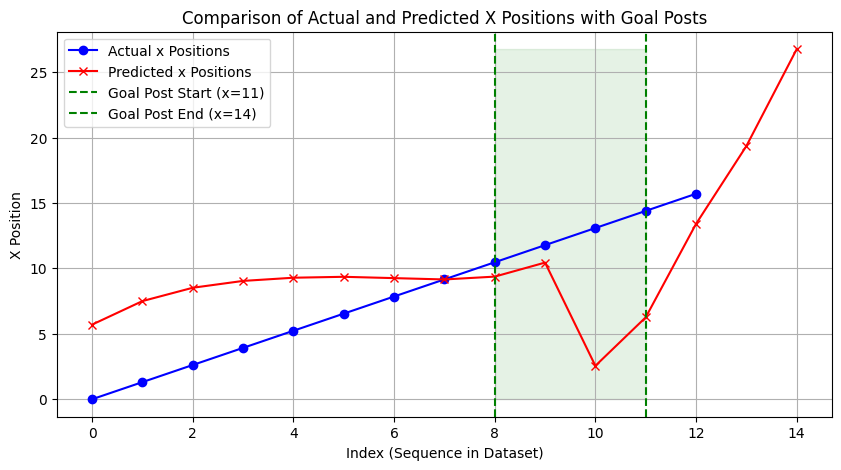

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# actual x positions
actual_x_positions = np.array([0.0, 1.3084617266825491, 2.6169234533650982, 3.925385180047647,
                               5.2338469067301965, 6.542308633412746, 7.850770360095294,
                               9.159232086777843, 10.467693813460393, 11.776155540142941])

# predicted x positions
predicted_x_positions = np.array([5.70370388, 7.50136995, 8.51977062, 9.04247284, 9.28615952,
                                  9.35622406, 9.25539207, 9.1537838, 9.37049103, 10.44326782,
                                  2.55371881, 6.25788736, 13.39840794, 19.34666634, 26.75013542])

plt.figure(figsize=(10, 5))
plt.plot(actual_x_positions, 'o-', label='Actual x Positions', color='blue')
plt.plot(predicted_x_positions, 'x-', label='Predicted x Positions', color='red')

# highlight the goal post area using vertical lines at the indices where x = 11 to x = 14 fall
goal_start_index = np.abs(actual_x_positions - 11).argmin()
goal_end_index = np.abs(actual_x_positions - 14).argmin()
plt.axvline(goal_start_index, color='green', linestyle='--', label='Goal Post Start (x=11)')
plt.axvline(goal_end_index, color='green', linestyle='--', label='Goal Post End (x=14)')
plt.fill_betweenx(y=[min(actual_x_positions.min(), predicted_x_positions.min()),
                     max(actual_x_positions.max(), predicted_x_positions.max())],
                 x1=goal_start_index, x2=goal_end_index, color='green', alpha=0.1)

#labels and legend
plt.xlabel('Index (Sequence in Dataset)')
plt.ylabel('X Position')
plt.title('Comparison of Actual and Predicted X Positions with Goal Posts')
plt.legend()
plt.grid(True)

plt.show()
